<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/MLP_model/RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2018-21시즌 데이터를 사용한 MLP model**
### Number of data = *29395*
선발 출전한 선수\
3월, 4월 데이터 제외\
0타수인 데이터 제외\
avLI, RE24, WPA feature 추가\
Validation data set 추가\
loss & acc graph
### Number of feature = *13*

1. avg (타율)
2. slg (장타율)
3. ops (출루율 + 장타율)
4. home/away_avg_y (홈/원정 별 타율)
5. avLI
6. RE24
7. WPA
8. vs_avg (상대 팀 타율)
9. recent_5days_avg (최근 5일 타율)
10. recent_5games_avg (최근 5경기 타율)
11. recent_10games_avg (최근 10경기 타율)
12. success_10days (최근 10일 성공률)
13. success_10games (최근 10경기 성공률)

acc = 0.8127



In [1]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
final_2018_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/final_2018_2021.csv', encoding='euc-kr')

In [ ]:
final_2018_2021

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games
0,강백호,404,한화,W 3:2,4,1B,1,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0,한화,home,0,0,0,0,NaN,한화,home,0,0,0,0,0.000,한화,1,home,0,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,강백호,406,LG,L 2:3,4,1B,1,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0,LG,home,3,2,0,0,0.667,LG,home,3,2,0,0,0.667,LG,0,home,0,0,0.000,0.666667,0.666667,0.666667,1.000000,1.000000
2,강백호,407,LG,W 7:3,4,1B,1,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0,LG,home,7,2,0,0,0.286,LG,home,7,2,0,0,0.286,LG,1,home,4,0,0.000,0.285714,0.285714,0.285714,0.500000,0.500000
3,강백호,408,LG,L 3:7,4,1B,1,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0,LG,home,11,5,0,0,0.455,LG,home,11,5,0,0,0.455,LG,1,home,8,3,0.375,0.454545,0.454545,0.454545,0.666667,0.666667
4,강백호,409,@삼성,L 5:7,4,1B,1,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0,삼성,away,15,7,0,0,NaN,삼성,away,15,7,0,0,0.000,삼성,1,away,0,0,0.000,0.466667,0.466667,0.466667,0.750000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39113,강경학,1006,@롯데,L 5:8,9,PH,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.277,NaN,0.393,0.775,6,0.39,-0.25,-0.012,0.0,롯데,away,133,35,108,32,0.296,롯데,away,133,35,108,32,0.296,롯데,0,away,15,3,0.200,0.250000,0.111111,0.200000,0.500000,0.400000
39114,강경학,1009,@KT,W 10:6,8,PH,0,3,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0.278,NaN,0.392,0.774,15,0.09,-0.03,-0.004,0.0,KT,away,133,35,109,32,0.294,KT,away,133,35,109,32,0.294,KT,1,away,36,12,0.333,0.000000,0.125000,0.222222,0.333333,0.400000
39115,강경학,1019,넥센,L 2:3,9,PR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,0.000,0.000,0,0.00,0.00,0.000,0.0,넥센,home,133,35,112,33,0.263,넥센,home,133,35,112,33,0.263,넥센,0,home,27,8,0.296,0.000000,0.222222,0.235294,1.000000,0.400000
39116,강경학,1020,넥센,L 5:7,7,PH,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,0.000,0.000,6,1.94,-0.47,-0.050,0.0,넥센,home,133,35,112,33,0.263,넥센,home,133,35,112,33,0.263,넥센,0,home,27,8,0.296,0.000000,0.250000,0.235294,0.000000,0.400000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


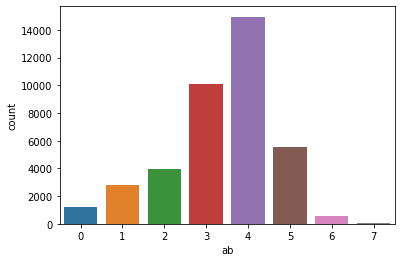

In [ ]:
sns.countplot(final_2018_2021['ab'])
plt.show()

In [5]:
#선발 출장에 한정
final_2018_2021 = final_2018_2021[final_2018_2021['start_member'] == 1]

In [6]:
#3월, 4월 데이터 제외
final_2018_2021 = final_2018_2021.loc[final_2018_2021['day']>= 500]

In [7]:
#0타수 데이터 제외
final_2018_2021 = final_2018_2021[final_2018_2021['ab']>0]

In [ ]:
final_2018_2021

### **Multi layer Perceptron in Be the legend**

In [8]:
mlp_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [ ]:
mlp_data

In [9]:
len(mlp_data)

29395

In [10]:
len(mlp_data[mlp_data['result_y'] == 1]) / len(mlp_data) * 100

67.47065827521688

In [12]:
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import minmax_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

### **Training data set / Test data set 분할**

In [13]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.3, random_state=50)

In [14]:
#현재 가지고 있는 모든 피쳐 사용

X_train = mlp_train.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_train = mlp_train.loc[:, ['result_y']]

X_test = mlp_test.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_test = mlp_test.loc[:, ['result_y']]

In [15]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [16]:
number_of_train_samples = X_train.shape[0]
width = X_train.shape[1]
X_train = X_train.reshape(number_of_train_samples, width)

In [17]:
number_of_test_samples = X_test.shape[0]
X_test = X_test.reshape(number_of_test_samples, width)

In [18]:
X_train = minmax_scale(X_train, feature_range=(0,1), axis = 0)
X_test = minmax_scale(X_test, feature_range=(0,1), axis = 0)

In [19]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### **Stratified K-Fold Cross Validation (auto)**

In [ ]:
mlp_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [ ]:
X = mlp_data.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y = mlp_data.loc[:, ['result_y']]

In [ ]:
X = mlp_data.loc[:, ['avg', 'slg', 'ops', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y = mlp_data.loc[:, ['result_y']]

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
number_of_samples = X.shape[0]
width = X.shape[1]
X = X.reshape(number_of_samples, width)

In [ ]:
X = minmax_scale(X, feature_range=(0,1), axis = 0)
y = to_categorical(y)

In [ ]:
def mlp_model_k():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['acc'])

    return model

In [ ]:
model = KerasClassifier(build_fn=mlp_model_k, epochs=150, batch_size=32, verbose=0)  

In [ ]:
 kfold = KFold(n_splits = 5, shuffle = True, random_state = 50) 
 results = cross_val_score(model, X, y, cv=kfold)

In [ ]:
results, round(np.mean(results),3)

(array([0.68293929, 0.69773769, 0.68634123, 0.68532062, 0.687702  ]), 0.688)

### **Validation data set / Training data set 분할**

In [25]:
X_val = X_train[:5000]
X_train = X_train[5000:]

y_val = y_train[:5000]
y_train = y_train[5000:]

### **MLP experiment**

In [23]:
# MLP model_1
# 3 layers & 64 units
# activation = sigmoid & softmax
# loss = binary_crossentrophy, optimizer = rmsprop
# loss: 0.4028 & acc: 0.8135

def mlp_model1():
    model = Sequential()

    model.add(Dense(64, input_dim= width, activation = 'sigmoid'))
    model.add(Dense(64, activation = 'sigmoid'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['acc'])

    return model

In [22]:
model1 = mlp_model1()
history = model1.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

NameError: ignored

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
# MLP model_2
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = rmsprop
# loss: 0.4365 & acc: 0.8042

def mlp_model2():
    model = Sequential()

    model.add(Dense(64, input_dim= width, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(2, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['acc'])

    return model

In [ ]:
model2 = mlp_model2()
history = model2.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
# MLP model_3
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = rmsprop
# initialization = kernel_initializer
# loss: 0.4474 & acc: 0.8026

def mlp_model3():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'glorot_uniform'))
    model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer = 'glorot_uniform'))
    model.add(Activation('relu'))
    model.add(Dense(2, kernel_initializer = 'glorot_uniform'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['acc'])

    return model

In [ ]:
model3 = mlp_model3()
history = model3.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model3.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
# MLP model_4
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = rmsprop
# initialization = HeNormal
# loss: 0.4607 & acc: 0.7965

def mlp_model4():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['acc'])

    return model

In [ ]:
model4 = mlp_model4()
history = model4.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model4.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
# MLP model_5
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = adam
# initialization = HeNormal
# loss: 0.4173 & acc: 0.8132

def mlp_model5():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['acc'])

    return model

In [ ]:
model5 = mlp_model5()
history = model5.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model5.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
# MLP model_6 
# Batch_Normal
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = adam
# initialization = HeNormal
# loss: 0.6793 & acc: 0.7383

def mlp_model6():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['acc'])

    return model

In [ ]:
model6 = mlp_model6()
history = model6.fit(X_train, y_train, epochs = 200, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model6.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
from keras.layers import Dropout

In [ ]:
# MLP model_7 
# Dropout
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = adam
# initialization = HeNormal
# loss: 0.4284 - acc: 0.7910

def mlp_model7():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['acc'])

    return model

In [ ]:
model7 = mlp_model7()
history = model7.fit(X_train, y_train, epochs = 200, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model7.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
# MLP model_8
# Batch_Normal
# Dropout
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = adam
# initialization = HeNormal
# loss: 0.5285 - acc: 0.7452

def mlp_model8():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['acc'])

    return model

In [ ]:
model8 = mlp_model8()
history = model8.fit(X_train, y_train, epochs = 200, validation_data=(X_val, y_val), verbose = 0)
history_dict = history.history

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model8.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# MLP model_ensemble
# Dropout
# 3 layers & 64 units
# activation = relu & sigmoid
# loss = binary_crossentrophy, optimizer = adam
# initialization = HeNormal
# loss: 0.5285 - acc: 0.7452

def mlp_model_en():
    model = Sequential()

    model.add(Dense(64, input_dim= width, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(64, kernel_initializer = 'HeNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(2, kernel_initializer = 'HeNormal'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['acc'])

    return model

In [ ]:
en_model1 = KerasClassifier(build_fn = mlp_model_en, epochs = 200, verbose = 0)
en_model1._estimator_type="classifier"
en_model2 = KerasClassifier(build_fn = mlp_model_en, epochs = 200, verbose = 0)
en_model2._estimator_type="classifier"
en_model3 = KerasClassifier(build_fn = mlp_model_en, epochs = 200, verbose = 0)
en_model3._estimator_type="classifier"

In [ ]:
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [ ]:
ensemble_clf = VotingClassifier(estimators = [('en_model1', en_model1), ('en_model2', en_model2), ('en_model3', en_model3)], voting = 'soft')
ensemble_clf.fit(X_train, y_train)

In [ ]:
y_pred = ensemble_clf.predict(X_test)
print('Acc: ', accuracy_score(y_pred, y_test))

### **SimpleRNN**

In [20]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [27]:
def simple_rnn():
    model = Sequential()

    model.add(SimpleRNN(50, input_shape = (width,1), return_sequences = False))
    model.add(Dense(20))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])
    
    return model

In [29]:
model = KerasClassifier(build_fn = simple_rnn, epochs = 200, batch_size = 50, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_test_ = np.argmax(y_test, axis = 1)
print(accuracy_score(y_pred, y_test_))

Epoch 1/200


ValueError: ignored

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model1.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])